In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import*
from scipy import ndimage as ndi
import napari
from skimage.morphology import*
from skimage.segmentation import*
from skimage.measure import*
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import*
from matplotlib.figure import*
import pandas as pd
import os
from skimage.filters import median
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from sklearn.metrics import r2_score
import pandas as pd
import warnings; warnings.simplefilter('ignore')
sns.set_style('ticks')

In [2]:
img = imread('D://Chromatic_abberation_corrections//x63_0-25um_BeadCroppedDemo.tif')
print(img.shape)

(101, 480, 480, 4)


In [3]:
#load the csv's
ch0 = pd.read_excel('ch0.xls')
ch1 = pd.read_excel('ch1.xls')
ch2 = pd.read_excel('ch2.xls')
ch3 = pd.read_excel('ch3.xls')

In [4]:
ch0.head()

,Name,Position X,Position Y,Position Z,Position T,Size Y,Size Z,Center X,Center Y,Center Z,Center T
0,spot #0,180.0,56.0,100.0,0.0,2.0,1.0,180.500000,56.500000,100.000000,0.0
1,spot #1,269.0,286.0,96.0,0.0,5.0,4.0,271.032787,288.000000,97.524590,0.0
2,spot #2,405.0,269.0,91.0,0.0,5.0,5.0,406.760000,270.733333,92.866667,0.0
3,spot #3,202.0,24.0,84.0,0.0,5.0,5.0,203.761194,25.955224,86.194030,0.0
4,spot #4,223.0,360.0,72.0,0.0,5.0,5.0,225.241379,361.793103,73.862069,0.0


In [5]:
def get_centroids(channel_data, channel_name):  #get the center x, y and z separately for each channel
    centroids = []
    for i in range(len(channel_data)):
        centroids.append(channel_data['Center'+' '+str(channel_name)][i])
    centroids = np.array(centroids)
    return centroids

In [6]:
centroids_0_z = get_centroids(ch0, 'Z')
centroids_0_y = get_centroids(ch0, 'Y')
centroids_0_x = get_centroids(ch0, 'X')

centroids_1_z = get_centroids(ch1, 'Z')
centroids_1_y = get_centroids(ch1, 'Y')
centroids_1_x = get_centroids(ch1, 'X')

centroids_2_z = get_centroids(ch2, 'Z')
centroids_2_y = get_centroids(ch2, 'Y')
centroids_2_x = get_centroids(ch2, 'X')

centroids_3_z = get_centroids(ch3, 'Z')
centroids_3_y = get_centroids(ch3, 'Y')
centroids_3_x = get_centroids(ch3, 'X')

In [7]:
diff_z01 = centroids_0_z - centroids_1_z
diff_z02 = centroids_0_z - centroids_2_z
diff_z03 = centroids_0_z - centroids_3_z

diff_z12 = centroids_1_z - centroids_2_z
diff_z13 = centroids_1_z - centroids_3_z
diff_z10 = centroids_1_z - centroids_0_z

diff_z23 = centroids_2_z - centroids_3_z
diff_z20 = centroids_2_z - centroids_0_z
diff_z21 = centroids_2_z - centroids_1_z

diff_z30 = centroids_3_z - centroids_0_z
diff_z31 = centroids_3_z - centroids_1_z
diff_z32 = centroids_3_z - centroids_2_z

In [8]:
#reshape the data
def reshape_z(z_centers):
    zshaped = z_centers.reshape(-1,1)
    return zshaped

In [9]:
z0 = reshape_z(centroids_0_z)
z1 = reshape_z(centroids_1_z)
z2 = reshape_z(centroids_2_z)
z3 = reshape_z(centroids_3_z)

In [10]:
reg01 = LinearRegression().fit(z0, diff_z01)
reg02 = LinearRegression().fit(z0, diff_z02)
reg03 = LinearRegression().fit(z0, diff_z03)

reg12 = LinearRegression().fit(z1, diff_z12)
reg13 = LinearRegression().fit(z1, diff_z13)
reg10 = LinearRegression().fit(z1, diff_z10)

reg23 = LinearRegression().fit(z2, diff_z23)
reg20 = LinearRegression().fit(z2, diff_z20)
reg21 = LinearRegression().fit(z2, diff_z21)

reg30 = LinearRegression().fit(z3, diff_z30)
reg31 = LinearRegression().fit(z3, diff_z31)
reg32 = LinearRegression().fit(z3, diff_z32)

In [11]:
m0 = reg01.coef_.tolist()+reg02.coef_.tolist()+reg03.coef_.tolist() #for channel 0 as base then to other channels
m1 = reg12.coef_.tolist()+reg13.coef_.tolist()+reg10.coef_.tolist()
m2 = reg23.coef_.tolist()+reg20.coef_.tolist()+reg21.coef_.tolist()
m3 = reg30.coef_.tolist()+reg31.coef_.tolist()+reg32.coef_.tolist()

c0 = [reg01.intercept_, reg02.intercept_, reg03.intercept_] #for channel 0 as base then to other channels
c1 = [reg12.intercept_, reg13.intercept_, reg10.intercept_]
c2 = [reg23.intercept_, reg20.intercept_, reg21.intercept_]
c3 = [reg30.intercept_, reg31.intercept_, reg32.intercept_]

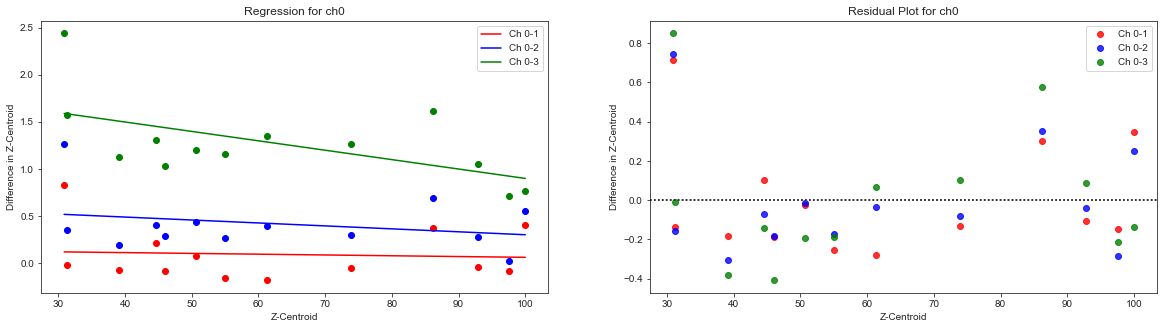

In [12]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)


ax1 = plt.scatter(centroids_0_z, diff_z01, color='red')
ax1 = plt.plot(centroids_0_z, reg01.predict(z0), color='red',label='Ch 0-1')
ax1 = plt.scatter(centroids_0_z, diff_z02, color='blue')
ax1 = plt.plot(centroids_0_z, reg02.predict(z0), color='blue',label='Ch 0-2')
ax1 = plt.scatter(centroids_0_z, diff_z03, color='green')
ax1 = plt.plot(centroids_0_z, reg03.predict(z0), color='green',label='Ch 0-3')
ax1 = plt.xlabel('Z-Centroid')
ax1 = plt.ylabel('Difference in Z-Centroid')
ax1 = plt.title('Regression for ch0')
ax1 = plt.legend()
ax2 = fig.add_subplot(122)
ax2 = sns.residplot(centroids_0_z, diff_z01, data=reg01.predict(z0), ax=ax2, color='red',label='Ch 0-1')
ax2 = sns.residplot(centroids_0_z, diff_z02, data=reg02.predict(z0), ax=ax2, color='blue',label='Ch 0-2')
ax2 = sns.residplot(centroids_0_z, diff_z03, data=reg03.predict(z0), ax=ax2, color='green',label='Ch 0-3')
ax2 = plt.xlabel('Z-Centroid')
ax2 = plt.ylabel('Difference in Z-Centroid')
ax2 = plt.title('Residual Plot for ch0')
ax2 = plt.legend()

In [13]:
reg_vals = pd.DataFrame({'m0':m0,'m1':m1,'m2':m2,'m3':m3,'c0':c0,'c1':c1,'c2':c2,'c3':c3})

In [14]:
reg_vals.head()

,m0,m1,m2,m3,c0,c1,c2,c3
0,-0.000834,-0.002282,-0.006839,0.010080,0.145089,0.468137,1.279034,-1.890243
1,-0.003128,-0.009124,0.003252,0.009137,0.614146,1.749559,-0.620498,-1.739564
2,-0.009980,0.000966,0.002297,0.006843,1.896890,-0.153241,-0.468291,-1.273415


In [15]:
reg_vals = reg_vals.append(pd.Series(0, index=reg_vals.columns), ignore_index=True)         ###Adding the same channel regression which is 0

In [16]:
reg_vals.head()

,m0,m1,m2,m3,c0,c1,c2,c3
0,-0.000834,-0.002282,-0.006839,0.010080,0.145089,0.468137,1.279034,-1.890243
1,-0.003128,-0.009124,0.003252,0.009137,0.614146,1.749559,-0.620498,-1.739564
2,-0.009980,0.000966,0.002297,0.006843,1.896890,-0.153241,-0.468291,-1.273415
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
size = img.shape
#z = 0.24 um

In [25]:
base_m0 = reg_vals['m0'].tolist()               ###Earlier it will taking the regression values along the rows, rather the columns 
base_c0 = reg_vals['c0'].tolist()

In [26]:
#Step-1:Calculate the z range
zstart = 0
zrange_um = np.linspace(zstart,zstart+(img.shape[0]-1)*0.24,img.shape[0])

In [31]:
#Step-2:Calculate the chromatic abberation equations for each channes
zshifts = []
for i in range(img.shape[3]):                                   ##iterating all the 4 channels of the image
    zshifts.append((zrange_um*base_m0[i])+base_c0[i]+zrange_um)
    
zshifts = np.array(zshifts)

In [32]:
minzrange = np.min(zshifts)
maxzrange = np.max(zshifts)
rangesize = maxzrange-minzrange
print(minzrange,maxzrange)

0.0 25.65736737745759


In [33]:
newrange = np.arange(zstart,zstart+rangesize,0.24)

In [34]:
zshifts2 = []
for i in range(img.shape[3]):
    zshifts2.append((newrange*base_m0[i])+base_c0[i])
zshifts2 = np.array(zshifts2)

In [35]:
zshifts2

array([[0.145089  , 0.14488889, 0.14468878, 0.14448867, 0.14428855,
        0.14408844, 0.14388833, 0.14368822, 0.14348811, 0.143288  ,
        0.14308789, 0.14288778, 0.14268767, 0.14248756, 0.14228745,
        0.14208733, 0.14188722, 0.14168711, 0.141487  , 0.14128689,
        0.14108678, 0.14088667, 0.14068656, 0.14048645, 0.14028634,
        0.14008623, 0.13988612, 0.139686  , 0.13948589, 0.13928578,
        0.13908567, 0.13888556, 0.13868545, 0.13848534, 0.13828523,
        0.13808512, 0.13788501, 0.1376849 , 0.13748478, 0.13728467,
        0.13708456, 0.13688445, 0.13668434, 0.13648423, 0.13628412,
        0.13608401, 0.1358839 , 0.13568379, 0.13548368, 0.13528357,
        0.13508345, 0.13488334, 0.13468323, 0.13448312, 0.13428301,
        0.1340829 , 0.13388279, 0.13368268, 0.13348257, 0.13328246,
        0.13308235, 0.13288223, 0.13268212, 0.13248201, 0.1322819 ,
        0.13208179, 0.13188168, 0.13168157, 0.13148146, 0.13128135,
        0.13108124, 0.13088113, 0.13068102, 0.13

In [46]:
newrange.shape

(107,)

In [47]:
nplanes = len(newrange)
zshifts_vx = np.round(zshifts2/0.24)

In [48]:
np.max(zshifts_vx[:,0])

8.0

In [49]:
np.max(zshifts_vx) 

8.0

In [50]:
czshifts = zshifts_vx-np.max(zshifts_vx)

In [51]:
czshifts = czshifts.astype(int)

In [52]:
czshifts

array([[-7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7,
        -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7,
        -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7,
        -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7,
        -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7,
        -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7,
        -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7],
       [-5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6,
        -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6,
        -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6,
        -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6,
        -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6,
        -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6],
       [ 0,  0,  0,  0,  0,  0

In [ ]:
#############################################################################################################################################################

In [54]:
img_corr = []
for z in range(nplanes):
    for j in range(img.shape[3]):
        zplanes = z+czshifts[j,i] 
        if zplanes < img.shape[0]:
            img_corr.append(img[zplanes,:,:,j])


In [ ]:
img_corr = np.array(img_corr)
print(img_corr.shape)

In [ ]:
#####! Debug #####!

In [62]:
imsave('Corrected_img.tif',img_corr)

In [58]:
v = napari.view_image(img_corr)

In [59]:
img2 = []
for i in range(img.shape[0]):
    for j in range(img.shape[3]):
        img2.append(img[i,:,:,j])

In [60]:
img2 = np.array(img2)
img2 = ndi.median_filter(img2,3)

In [61]:
n = napari.view_image(img2)